# Goals

* Display a graph of agent/tool calls in the `SRAgent find-datasets` workflow

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import numpy as np
from pathlib import Path

In [2]:
# get base directory
base_dir = !git rev-parse --show-toplevel
base_dir = Path(base_dir[0])
base_dir

PosixPath('/home/nickyoungblut/dev/python/scBaseCount_analysis')

In [3]:
# Define the tool data
tool_data = {
    'invoke_find_datasets_workflow': 80.171162,
    'invoke_sragent_agent': 47.577161,
    'invoke_tissue_ontology_workflow': 44.598162,
    'invoke_tissue_ontology_agent': 33.664545,
    'invoke_entrez_agent': 26.859475,
    'invoke_ncbi_fetch_agent': 11.956634,
    'invoke_bigquery_agent': 10.531875,
    'invoke_efetch_agent': 8.543383,
    'invoke_esummary_agent': 7.217007,
    'fetch_bioproject_record': 4.685145,
    'invoke_esearch_agent': 3.190766,
    'invoke_find_datasets_agent': 2.960510,
    'invoke_elink_agent': 2.022246,
    'which_entrez_databases': 2.011831,
    'fetch_biosample_record': 1.976901,
    'fetch_ncbi_record': 1.878156,
    'get_study_experiment_run': 1.551075,
    'esearch': 1.521951,
    'get_experiment_metadata': 1.416495,
    'get_neighbors': 1.414890,
    'efetch': 1.337617,
    'get_run_metadata': 1.285950,
    'get_study_metadata': 1.280950,
    'fetch_geo_record': 1.171605,
    'esearch_scrna': 1.084330,
    'query_vector_db': 1.030593,
    'esummary': 0.953450,
    'query_uberon_ols': 0.631449,
    'elink': 0.366440,
}

# Create a directed graph
G = nx.DiGraph()

# Add nodes with duration as attribute
for tool, duration in tool_data.items():
    G.add_node(tool, duration=duration)

# Define the hierarchy based on the codebase analysis
edges = [
    # Main workflow
    ('invoke_find_datasets_workflow', 'invoke_find_datasets_agent'),
    ('invoke_find_datasets_workflow', 'invoke_sragent_agent'),
    ('invoke_sragent_agent', 'invoke_entrez_agent'),
    ('invoke_sragent_agent', 'invoke_ncbi_fetch_agent'),
    ('invoke_sragent_agent', 'invoke_bigquery_agent'),
    ('invoke_sragent_agent', 'invoke_tissue_ontology_workflow'),
    
    # Tissue ontology workflow
    ('invoke_tissue_ontology_workflow', 'invoke_tissue_ontology_agent'),
    ('invoke_tissue_ontology_agent', 'query_uberon_ols'),
    
    # Find datasets agent
    ('invoke_find_datasets_agent', 'esearch_scrna'),
    
    # Entrez agent and its tools
    ('invoke_entrez_agent', 'invoke_esearch_agent'),
    ('invoke_entrez_agent', 'invoke_efetch_agent'),
    ('invoke_entrez_agent', 'invoke_esummary_agent'),
    ('invoke_entrez_agent', 'invoke_elink_agent'),
    ('invoke_entrez_agent', 'which_entrez_databases'),
    
    # Direct tool calls from Entrez sub-agents
    ('invoke_esearch_agent', 'esearch'),
    ('invoke_efetch_agent', 'efetch'),
    ('invoke_esummary_agent', 'esummary'),
    ('invoke_elink_agent', 'elink'),
    ('invoke_elink_agent', 'get_neighbors'),
    
    # NCBI Fetch agent and its tools
    ('invoke_ncbi_fetch_agent', 'fetch_bioproject_record'),
    ('invoke_ncbi_fetch_agent', 'fetch_biosample_record'),
    ('invoke_ncbi_fetch_agent', 'fetch_ncbi_record'),
    ('invoke_ncbi_fetch_agent', 'fetch_geo_record'),
    
    # BigQuery agent and its tools
    ('invoke_bigquery_agent', 'get_study_experiment_run'),
    ('invoke_bigquery_agent', 'get_experiment_metadata'),
    ('invoke_bigquery_agent', 'get_run_metadata'),
    ('invoke_bigquery_agent', 'get_study_metadata'),
    
    # Vector DB might be used by tissue ontology
    ('invoke_tissue_ontology_agent', 'query_vector_db'),
]

# Add edges to the graph
G.add_edges_from(edges)

In [4]:
# Verify all nodes have duration data
missing_nodes = set(G.nodes()) - set(tool_data.keys())
if missing_nodes:
    print(f"Warning: Missing duration data for nodes: {missing_nodes}")

# Calculate depth of each node for hierarchical positioning
root = 'invoke_find_datasets_workflow'
depths = nx.single_source_shortest_path_length(G, root)

Note: Graphviz not available, using custom hierarchical layout
✓ Saved hierarchy graph to '/home/nickyoungblut/dev/python/scBaseCount_analysis/figures/sragent_hierarchy_graph_time.svg'


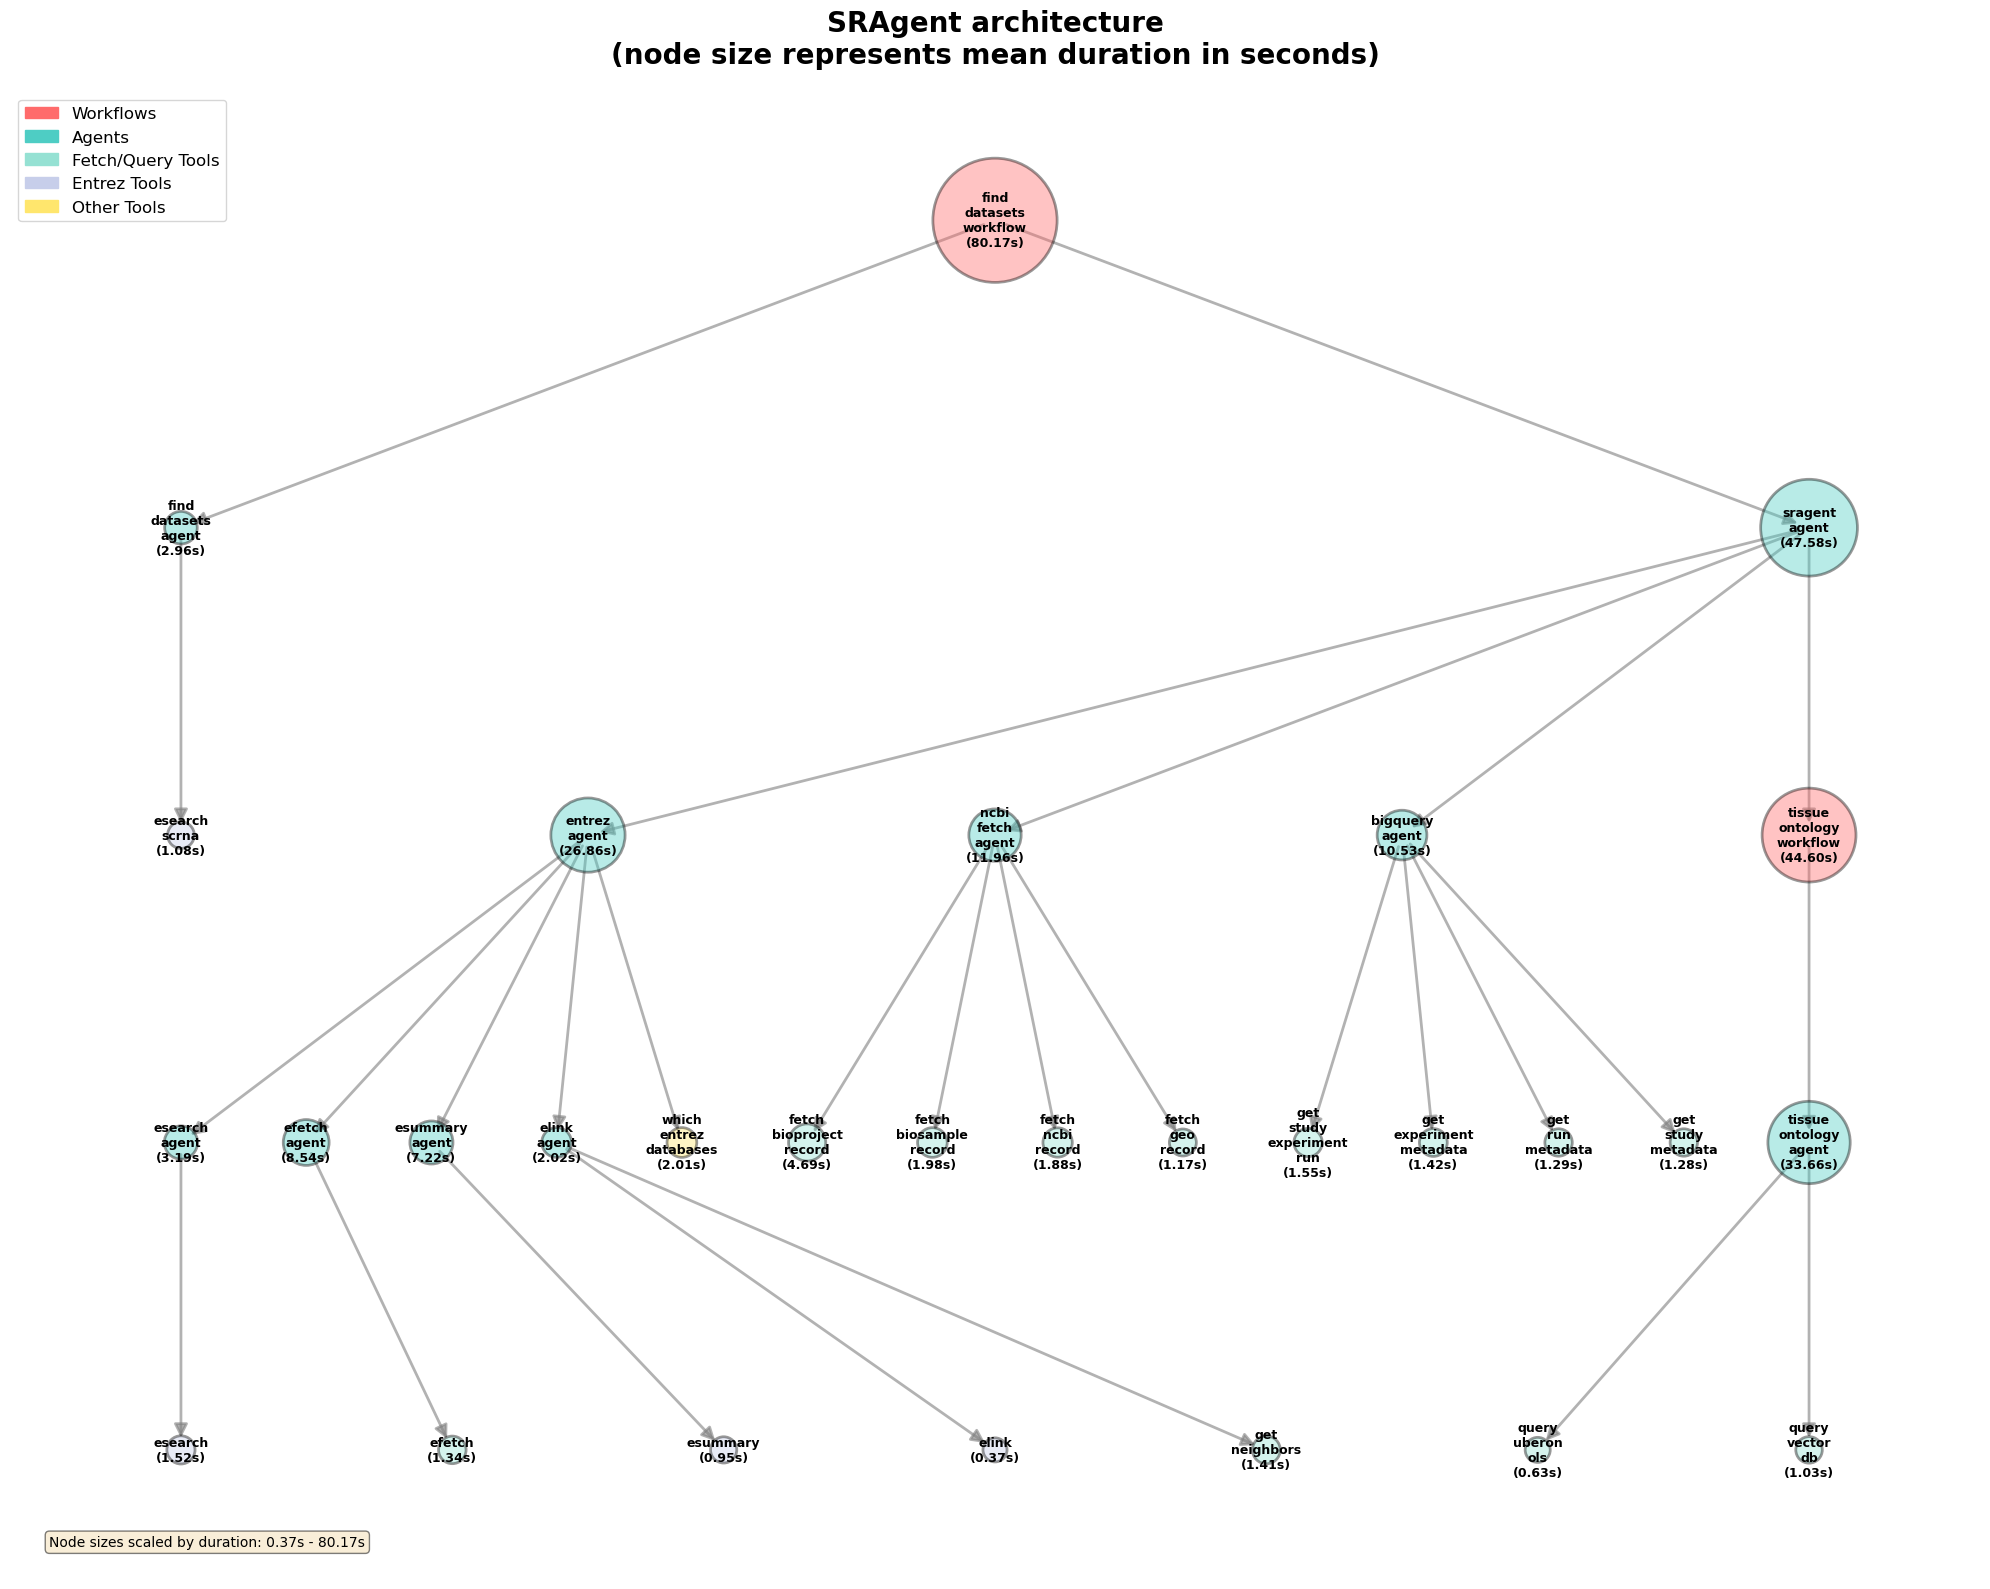

In [9]:
# Alternative: Create custom hierarchical layout
def create_hierarchical_layout(G, root, width=6, height=1.5):
    """Create a hierarchical layout without graphviz"""
    pos = {}
    levels = {}
    
    # Group nodes by depth
    for node, depth in depths.items():
        if depth not in levels:
            levels[depth] = []
        levels[depth].append(node)
    
    # Position nodes
    for depth, nodes in levels.items():
        n_nodes = len(nodes)
        for i, node in enumerate(nodes):
            # Spread nodes horizontally at each level
            x = (i - (n_nodes - 1) / 2) * width / max(1, n_nodes - 1)
            y = -depth * height
            pos[node] = (x, y)
    
    return pos

# Create the plot
plt.figure(figsize=(20, 16))

# Use hierarchical layout with fallback
try:
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
except:
    # Fallback to custom hierarchical layout if graphviz is not available
    print("Note: Graphviz not available, using custom hierarchical layout")
    pos = create_hierarchical_layout(G, root)

# Normalize node sizes based on duration (scale between 300 and 8000)
durations = [tool_data[node] for node in G.nodes()]
min_duration = min(durations)
max_duration = max(durations)
node_sizes = [300 + (duration - min_duration) / (max_duration - min_duration) * 7700 
              for duration in durations]

# Define colors for different agent types
node_colors = []
for node in G.nodes():
    if 'workflow' in node:
        node_colors.append('#FF6B6B')  # Red for workflows
    elif 'agent' in node:
        node_colors.append('#4ECDC4')  # Teal for agents
    elif any(x in node for x in ['fetch', 'get', 'query']):
        node_colors.append('#95E1D3')  # Light green for fetch/get/query tools
    elif any(x in node for x in ['esearch', 'efetch', 'esummary', 'elink']):
        node_colors.append('#C7CEEA')  # Light purple for Entrez tools
    else:
        node_colors.append('#FFE66D')  # Yellow for other tools

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, 
                       alpha=0.4, linewidths=2, edgecolors='black')
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                       arrowsize=20, arrowstyle='-|>', width=2, alpha=0.6)

# Add labels with duration
labels = {}
for node in G.nodes():
    duration = tool_data[node]
    # Shorten long names for readability
    short_name = node.replace('invoke_', '').replace('_', ' ')
    short_name = short_name.replace(' ', '\n')
    labels[node] = f"{short_name}\n({duration:.2f}s)"

nx.draw_networkx_labels(G, pos, labels, font_size=9, font_weight='bold')

# Add title and legend
plt.title("SRAgent architecture\n(node size represents mean duration in seconds)", 
          fontsize=20, fontweight='bold', pad=20)

# Create custom legend
legend_elements = [
    mpatches.Patch(color='#FF6B6B', label='Workflows'),
    mpatches.Patch(color='#4ECDC4', label='Agents'),
    mpatches.Patch(color='#95E1D3', label='Fetch/Query Tools'),
    mpatches.Patch(color='#C7CEEA', label='Entrez Tools'),
    mpatches.Patch(color='#FFE66D', label='Other Tools')
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=12)

# Add note about node sizes
plt.text(0.02, 0.02, f"Node sizes scaled by duration: {min_duration:.2f}s - {max_duration:.2f}s", 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.axis('off')
plt.tight_layout()

svg_path = base_dir / 'figures' / 'sragent_hierarchy_graph_time.svg'
plt.savefig(svg_path, format='svg', bbox_inches='tight', facecolor='white')
print(f"✓ Saved hierarchy graph to '{svg_path}'")

plt.show()

# session info

In [10]:
!conda list

# packages in environment at /home/nickyoungblut/miniforge3/envs/SRAgent_nb:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
_python_abi3_support      1.0                  hd8ed1ab_2    conda-forge
aiobotocore               2.23.0             pyhd8ed1ab_0    conda-forge
aiohappyeyeballs          2.6.1              pyhd8ed1ab_0    conda-forge
aiohttp                   3.11.14                  pypi_0    pypi
aioitertools              0.12.0             pyhd8ed1ab_1    conda-forge
aiosignal                 1.3.2              pyhd8ed1ab_0    conda-forge
anndata                   0.11.4             pyhd8ed1ab_0    conda-forge
annotated-types           0.7.0                    pypi_0    pypi
anthropic                 0.57.1                   pypi_0    pypi
anyio                     4.9.0                    pypi_0    pypi
appdir